# An exercise in stratified sampling with Spark

Stratified sampling is a way to reduce a dataset while keeping the distribution of certain characteristics similar to the original.

For example, if we have a very large dataset we may want to make it smaller to make processing and experimenting with it easier.

- We could take a random sample, but this will probably mean the distribution of the data will not match the original.
    - Perhaps the original data was skewed toward a certain age group and gender in which case random sampling may change the shape of the data

With stratified sampling, the aim is to keep the proportions similar to the original.

The wikipedia page has a good example which I try to recreate below.
- https://en.wikipedia.org/wiki/Stratified_sampling
- https://spark.apache.org/docs/3.5.1/mllib-statistics.html#stratified-sampling

## Set up spark

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark = SparkSession \
       .builder \
       .appName("data processing experiment") \
       .getOrCreate()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,375 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,125 kB]
Fetched 3,733 kB in 2s (1,979 kB/s)
Reading package lists... Do

In [ ]:
from pyspark.sql.functions import col

seed = 4

## Utility function to load data from CSV

In [ ]:
from pyspark.sql.functions import *;
from pyspark.sql.types import *;

def load(file_location):
    file_type = "csv"

    # CSV options
    infer_schema = "true"
    first_row_is_header = "true"
    delimiter = ","

    # The applied options are for CSV files. For other file types, these will be ignored.
    df = spark.read.format(file_type) \
    .option("inferSchema", infer_schema) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .load(file_location)

    return df

## Source the data from git

In [ ]:
%%shell

if [ ! -d "/tmp/data" ]; then
  echo "Cloning data"
  git clone https://github.com/prule/data.git /tmp/data
else
  echo "Pulling data"
  cd /tmp/data && git pull
fi

Cloning data
Cloning into '/tmp/data'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 62 (delta 14), reused 51 (delta 3), pack-reused 0
Receiving objects: 100% (62/62), 6.86 KiB | 6.86 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
# generate large dataset
%%shell
cd /tmp/data/ && ./run sample4:generate


Generating large data



In [ ]:
# print number of files in directory
import os
print (len(os.listdir("/tmp/data/sample4/large/")))

1000


In [ ]:
raw = load("file:/tmp/data/sample4/large/")
raw.count()

180000

The raw data has 180,000 rows - our aim here is to produce a smaller dataset of 40,000 rows, but with the same proportions of the 4 combinations of sex and status.

## Show distribution of data by sex and status

In [ ]:
rawProportions = raw.groupBy("sex","status").count() \
  .withColumn("proportion", col('count')/raw.count()) \
  .withColumn("label", concat(col('sex'), lit("|"), col('status'))) \
  .orderBy("sex","status")
rawProportions.show()

+------+---------+-----+----------+----------------+
|   sex|   status|count|proportion|           label|
+------+---------+-----+----------+----------------+
|Female|Full-time| 9000|      0.05|Female|Full-time|
|Female|Part-time|63000|      0.35|Female|Part-time|
|  Male|Full-time|90000|       0.5|  Male|Full-time|
|  Male|Part-time|18000|       0.1|  Male|Part-time|
+------+---------+-----+----------+----------------+



<Axes: ylabel='proportion'>

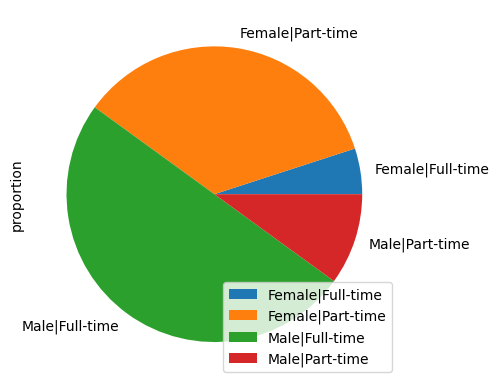

In [ ]:
values = rawProportions.toPandas()
values.plot(kind='pie', y='proportion', labels=values['label'])


## Transform the data
I'm not sure how to sample the data by multiple columns, so to make it simple I'll add a column which is the concatenation of sex and status. Then I can just sample by that column.

In [ ]:
transformed = raw.withColumn( \
    'sample_by', \
    concat( \
        col("sex"), \
        lit("|"), \
        col("status") \
    ) \
)

transformed.head(5)

[Row(Sex='Male', Status='Full-time', Id=1, sample_by='Male|Full-time'),
 Row(Sex='Male', Status='Full-time', Id=2, sample_by='Male|Full-time'),
 Row(Sex='Male', Status='Full-time', Id=3, sample_by='Male|Full-time'),
 Row(Sex='Male', Status='Full-time', Id=4, sample_by='Male|Full-time'),
 Row(Sex='Male', Status='Full-time', Id=5, sample_by='Male|Full-time')]

Calculate the proportions for each segment
If we have 180 rows and we want to reduce that to 40 we need to sample 40/180 = approx 22%.

And we want to take equal proportions of each segment (in this example) so the sample proportions will match the original data.
```
 {
     'Male|Full-time':0.22,
     'Male|Part-time':0.22,
     'Female|Full-time':0.22,
     'Female|Part-time':0.22
 }
 ```

In [ ]:
fractions = transformed.select("sample_by") \
  .distinct() \
  .withColumn("fraction", lit(.22)) \
  .rdd.collectAsMap()
print(fractions)

{'Male|Full-time': 0.22, 'Female|Part-time': 0.22, 'Female|Full-time': 0.22, 'Male|Part-time': 0.22}


## Perform the sampling

In [ ]:
sample = transformed.stat.sampleBy( \
  col="sample_by", \
  fractions=fractions, \
  seed=12 \
)

sample.count()

39631

We now have approximately 40,000 rows.

## Look at the proportions for the sample

In [ ]:
sampledProportions = sample \
    .groupBy("sex","status") \
    .count() \
    .withColumn("proportion", (col('count')/sample.count()).cast(DecimalType(10,2))) \
    .orderBy("sex","status")

sampledProportions.show()

+------+---------+-----+----------+
|   sex|   status|count|proportion|
+------+---------+-----+----------+
|Female|Full-time| 1907|      0.05|
|Female|Part-time|13904|      0.35|
|  Male|Full-time|19911|      0.50|
|  Male|Part-time| 3909|      0.10|
+------+---------+-----+----------+



And the proportions of each combination of sex and status is the same as the original data.

Lets look at what happens with a random sampling...

In [ ]:
raw.sample(fraction=0.22, seed=12).groupBy("sex","status") \
    .count() \
    .withColumn("proportion", (col('count')/sample.count()).cast(DecimalType(10,2))) \
    .orderBy("sex","status") \
    .show()

+------+---------+-----+----------+
|   sex|   status|count|proportion|
+------+---------+-----+----------+
|Female|Full-time| 1907|      0.05|
|Female|Part-time|13904|      0.35|
|  Male|Full-time|19911|      0.50|
|  Male|Part-time| 3909|      0.10|
+------+---------+-----+----------+



It's exactly the same! No point in all that complexity in this example. Perhaps if we wanted to CHANGE the proportions (use unequal fractions) then we could do it that way. (Perhaps for manufacturing some sample data?)

If we use a small dataset we can see the proportions are close to expected but not quite exact - that is, the bigger the dataset the more accurate the proportions will be.

In [ ]:
small = load("file:/tmp/data/sample4/small/")
small.groupBy("sex","status") \
    .count() \
    .withColumn("proportion", (col('count')/small.count()).cast(DecimalType(10,2))) \
    .orderBy("sex","status") \
    .show()

smallSample = small.sample(fraction=0.22, seed=12)

smallSample.groupBy("sex","status") \
    .count() \
    .withColumn("proportion", (col('count')/smallSample.count()).cast(DecimalType(10,2))) \
    .orderBy("sex","status") \
    .show()

+------+---------+-----+----------+
|   sex|   status|count|proportion|
+------+---------+-----+----------+
|Female|Full-time|    9|      0.05|
|Female|Part-time|   63|      0.35|
|  Male|Full-time|   90|      0.50|
|  Male|Part-time|   18|      0.10|
+------+---------+-----+----------+

+------+---------+-----+----------+
|   sex|   status|count|proportion|
+------+---------+-----+----------+
|Female|Full-time|    1|      0.02|
|Female|Part-time|   14|      0.32|
|  Male|Full-time|   24|      0.55|
|  Male|Part-time|    5|      0.11|
+------+---------+-----+----------+

